# Analyzing inference pipeline runs


As an AlphaFold inference pipeline executes inference workflow steps, information about a step's outcome, including artifacts and artifact metadata generated by a step, is tracked in Vertex ML Metadata. For example, a model prediction step tracks the locations of raw prediction and protein structure files and properties like ranking confidence. The tracked information ensures reproducibility and supports detailed run analysis including lineage tracing. 


In this notebook, you will explore how to retrieve pipeline run metadata from Vertex AI Metadata, explore its properties and visualize generated artifacts.

### Install and import required packages

In [ ]:
! pip install py3dmol
! pip install dm-tree
! pip install matplotlib
! pip install biopython
! pip install ipywidgets

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import py3Dmol
from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output
from google.cloud import aiplatform_v1 as vertex_ai

from src.analysis import notebook_utils
from src.analysis import parsers
from src.analysis import utils

## Pipeline metadata exploration

In this section of the notebook, you will use Vertex AI SDK to retrieve information about pipeline runs, including information about artifacts and metadata tracked by a run.

### Define API clients to interact with Vertex AI Pipelines metadata

Change the variables in the next cell according to your environment's definition.

In [2]:
PROJECT_ID = 'alphafold-deploy-0525'
REGION = 'us-central1'  # Replace with your region
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# PROJECT_ID = '<YOUR PROJECT ID>'    # Replace with your project ID
# REGION = '<YOUR REGION>'  # Replace with your region
# API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# Create Pipelines and Metadata service clients
client_pipeline = vertex_ai.PipelineServiceClient(client_options={"api_endpoint": API_ENDPOINT})
client_metadata = vertex_ai.MetadataServiceClient(client_options={"api_endpoint": API_ENDPOINT})

### Listing all running pipelines

You can list all pipelines in a given state. For example all pipelines that are still running.  
The following cell creates a request to list all the running Pipelines.

In [3]:
FILTER = 'state="PIPELINE_STATE_RUNNING"'

list_pipelines_request = vertex_ai.ListPipelineJobsRequest(
    parent=f'projects/{PROJECT_ID}/locations/{REGION}',
    filter=FILTER
)

list_pipelines = list(client_pipeline.list_pipeline_jobs(list_pipelines_request))

if list_pipelines:
    print(f'There are {len(list_pipelines)} pipeline(s) running.')
    for pipeline in list_pipelines:
        print(f'ID: {pipeline.name} - State: {pipeline.state.name}')
else:
    print('No pipelines running.')

No pipelines running.


### Listing all pipelines with a specific label

You can search for all pipelines annotated with a specific label. For example, you can list all pipelines that were grouped under a given experiment.

Set the `experiment_id` variable to a label you used to a annotate pipeline run for the monomer optimized pipeline.

In [5]:
experiment_id = 't1050-universal'  # Replace with your label (lower case)
FILTER = f'labels.experiment_id="{experiment_id}"'

list_pipelines_request = vertex_ai.ListPipelineJobsRequest(
    parent=f'projects/{PROJECT_ID}/locations/{REGION}',
    filter=FILTER
)

list_pipelines = list(client_pipeline.list_pipeline_jobs(list_pipelines_request))

print(f'Number of Pipeline(s) found: {len(list_pipelines)}')

if list_pipelines:
    print(f'Printing pipeline(s) with label `experiment_id` equals to `{experiment_id}`.')
    for pipeline in list_pipelines:
        print(f'Id: {pipeline.name} - State: {pipeline.state.name}')
else:
    print('No pipelines found.')

Number of Pipeline(s) found: 9
Printing pipeline(s) with label `experiment_id` equals to `t1050-universal`.
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220616184659 - State: PIPELINE_STATE_FAILED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220614152013 - State: PIPELINE_STATE_SUCCEEDED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220614151845 - State: PIPELINE_STATE_CANCELLED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220613223501 - State: PIPELINE_STATE_SUCCEEDED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220613221734 - State: PIPELINE_STATE_SUCCEEDED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220613221548 - State: PIPELINE_STATE_FAILED
Id: projects/569249717177/locations/us-central1/pipelineJobs/alp

### Retrieving artifact metadata

You can retrieve metadata for artifacts generated by a pipeline. For example, you can retrieve ranking confidence from a raw prediction artifact generated by a model predict step.

You will construct a data structure containing all information generated by a pipeline.

You need to use a full ID of the pipeline in the format `projects/<PROJECT NUMBER>/locations/<REGION>/pipelineJobs/<PIPELINE NAME>`. Set the `pipeline_id` variable to the ID of a successful run returned by the previous cell.

**IMPORTANT**: Please change the variables `pipeline_id`, `is_universal_pipeline` and `is_monomer` according to the definitions of the pipeline you chose.

In [6]:
# Change to your pipeline ID
# pipeline_id = '<YOUR PIPELINE ID>'
pipeline_id = 'projects/569249717177/locations/us-central1/pipelineJobs/alphafold-inference-pipeline-20220614152013'
# Change to False if you are using the Monomer-Optimized Pipeline
is_universal_pipeline = True
# Change to False if multimer
is_monomer = True

if is_monomer:
  model_type_to_use = notebook_utils.ModelType.MONOMER
else:
  model_type_to_use = notebook_utils.ModelType.MULTIMER

In [7]:
get_request = vertex_ai.GetPipelineJobRequest(
    name=pipeline_id
)
pipeline_job = client_pipeline.get_pipeline_job(get_request)

After you have the data structure you can browse it and retrieve the required properties. In the following example, you will retrieve the `ranking_confidence` values tracked by model prediction steps.

In [8]:
# Retrieve all tasks with name = predict
predict_tasks = [i for i in pipeline_job.job_detail.task_details if i.task_name == 'predict']
formated_predict_tasks = []

for t in predict_tasks:
    task_id = t.task_id
    parent_task_id = t.parent_task_id
    model_name = t.execution.metadata['input:model_name']
    ranking_confidence = t.outputs['raw_prediction'].artifacts[0].metadata['ranking_confidence']
    uri = t.outputs['raw_prediction'].artifacts[0].uri

    formated_predict_tasks.append(
        {
            'task_id': task_id,
            'parent_task_id': parent_task_id,
            'model_name': model_name,
            'ranking_confidence': ranking_confidence,
            'uri': uri
        }
    )

# Sort predict tasks by ranking confidence
sorted_predict = sorted(formated_predict_tasks, key=lambda x: x['ranking_confidence'], reverse=True)

In [9]:
print('Preditions ranking:')
for prediction in sorted_predict:
    print(prediction['model_name'], '=>', 'Ranking confidence:', prediction['ranking_confidence'])

Preditions ranking:
model_2 => Ranking confidence: 92.38234691004513
model_1 => Ranking confidence: 92.37382823522739
model_4 => Ranking confidence: 92.15136591681073
model_3 => Ranking confidence: 92.06861978331986
model_5 => Ranking confidence: 91.31221195356736


Artifacts generated by Alphafold pipelines have a metadata property called `category`, which helps with artifact discovery and metadata retrieval.  
Let's find all the Artifacts with the `category` property set to `msa`. These artifacts capture information about MSAs generated during feature engineering phase.

In [10]:
pipeline_ctx = pipeline_job.job_detail.pipeline_run_context.name
parent = f'projects/{PROJECT_ID}/locations/{REGION}/metadataStores/default'

# Filter which artifacts to present
if is_universal_pipeline:
    FILTER = f'in_context("{pipeline_ctx}") AND display_name="msas"'
else:
    FILTER = f'in_context("{pipeline_ctx}") AND metadata.category.string_value="msa"'

list_artifacts_request = vertex_ai.ListArtifactsRequest(
    parent=parent,
    filter=FILTER
)

msas = list(client_metadata.list_artifacts(request=list_artifacts_request))

You can now display all the properties associated with MSA artifacts.

In [11]:
msa_uri = ''

if is_universal_pipeline:
    for k, v in msas[0].metadata.items():
        print(f'Database: {k.split(sep=".")[0][:-5]} | Number hits: {v}')
        if 'bfd' in k:
            if is_monomer:
                msa_uri = os.path.join(msas[0].uri, k.split(sep='/')[-1])
            else:
                msa_uri = os.path.join(msas[0].uri, k)
            msa_filename = msa_uri.split(sep='/')[-1]
            msa_file_extension = msa_filename.split(sep='.')[-1]
else:
    for msa in msas:
        if msa.display_name != 'template_hits':
            print(f'Database: {msa.metadata["databases"]} | Number of hits: {msa.metadata["num_sequences"]} | Tool: {msa.metadata["tool"]}')
            if msa.metadata["databases"][0] == 'bfd':
                msa_uri = msa.uri
                msa_file_extension = msa.metadata["data_format"]
                msa_filename = msa_uri.split(sep='/')[-1]
        else:
            print(f'Template hits: {msa.metadata["num_hits"]} | Tool: {msa.metadata["tool"]}')

Database: msas/bfd_uniclust | Number hits: 4961.0
Database: msas/mgnify | Number hits: 501.0
Database: msas/uniref90 | Number hits: 10000.0
Database: msas/pdb | Number hits: 500.0


Since an artifact entry in Vertex Metadata contains a link to the location of artifact file(s) in Google Cloud storage, you can retrieve the artifact for further, local analysis.

For example, you can download an MSA file and use AlphaFold notebook widgets to visualize it.

In [12]:
! gsutil cp {msa_uri} .

Copying gs://alphafold-deploy-0525-bucket/pipeline_runs/universal-pipeline/569249717177/alphafold-inference-pipeline-20220614152013/data-pipeline_-7717031760952819712/msas/bfd_uniclust_hits.a3m...
/ [1 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 1 objects/4.3 MiB.                                      


The next cell can take up to 30 seconds to execute.


4961 unique sequences found in total for sequence 0



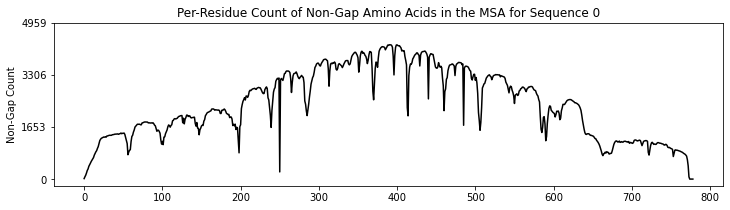

In [13]:
with open(msa_filename, 'r') as fp:
    msa_file = fp.read()

if msa_file_extension == 'a3m':
    msa_parsed = parsers.parse_a3m(msa_file)
elif msa_file_extension == 'sto':
    msa_parsed = parsers.parse_stockholm(msa_file)

notebook_utils.show_msa_info([msa_parsed], 0)

# Visualize Prediction

Next you will visualise the prediction & confidence.
You need to download two files for this step:
 - Prediction pickle file
 - Relaxed protein PDB file

If the multimer model has been used, it will show the structure coloured by chain.

In [14]:
# Find the `Relax` task to get its URI
for t in pipeline_job.job_detail.task_details:
    if t.parent_task_id == sorted_predict[0]['parent_task_id'] and 'condition' in t.task_name:
        condition_relax_parent_id = t.task_id
        break

for t in pipeline_job.job_detail.task_details:
    if t.parent_task_id == condition_relax_parent_id:
        top_relax_predict = t.outputs['relaxed_protein'].artifacts[0].uri
        break

In [15]:
! gsutil cp {sorted_predict[0]["uri"]} .
! gsutil cp {top_relax_predict} .

Copying gs://alphafold-deploy-0525-bucket/pipeline_runs/universal-pipeline/569249717177/alphafold-inference-pipeline-20220614152013/predict_-5781398714857816064/raw_prediction.pkl...
- [1 files][183.6 MiB/183.6 MiB]                                                
Operation completed over 1 objects/183.6 MiB.                                    
Copying gs://alphafold-deploy-0525-bucket/pipeline_runs/universal-pipeline/569249717177/alphafold-inference-pipeline-20220614152013/relax_8290098320861298688/relaxed_protein.pdb...
/ [1 files][964.3 KiB/964.3 KiB]                                                
Operation completed over 1 objects/964.3 KiB.                                    


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

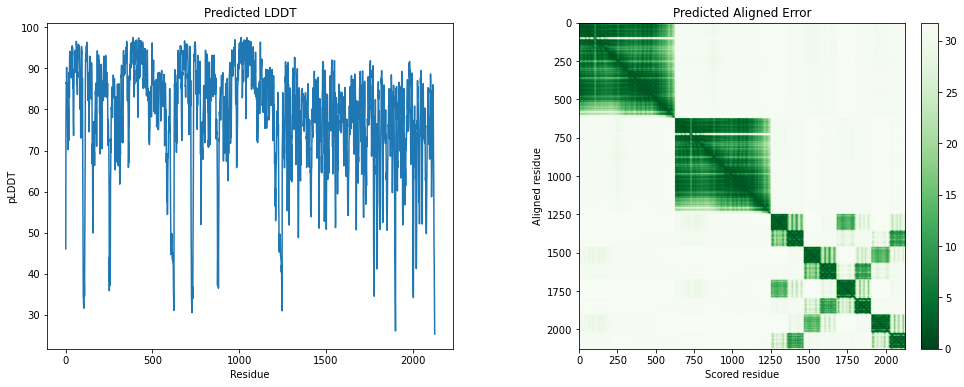

In [37]:
with open('raw_prediction.pkl', 'rb') as fp:
    raw_predictions = pickle.load(fp)

with open('relaxed_protein.pdb', 'r') as fp:
    relaxed_pdb = fp.read()

# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

banded_b_factors = []
final_atom_mask = raw_predictions['structure_module']['final_atom_mask']

for plddt in raw_predictions['plddt']:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)

show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = ['Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

# Show the structure coloured by chain if the multimer model has been used.
if model_type_to_use == notebook_utils.ModelType.MULTIMER:
  multichain_view = py3Dmol.view(width=800, height=600)
  multichain_view.addModelsAsFrames(to_visualize_pdb)
  multichain_style = {'cartoon': {'colorscheme': 'chain'}}
  multichain_view.setStyle({'model': -1}, multichain_style)
  multichain_view.zoomTo()
  multichain_view.show()

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

if 'predicted_aligned_error' in raw_predictions:
  num_plots = 2
  pae = raw_predictions['predicted_aligned_error']
  max_pae = raw_predictions['max_predicted_aligned_error']
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(raw_predictions['plddt'])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')